# Comparison of Texas Wind Power Capacity Estimates

Import required Python modules

In [445]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

Set directory path where geospatial data files are stored

In [446]:
datapath = "/home/tomortiz/projects/geospatial/data"

## NREL WINDExchange Total Technical Wind Power Capacity

The National Renewable Energy Laboratory (NREL) publishes maps and associated data tables to quantify the wind power potential over the entire United States.  These maps attempt to estimate the total technical wind power capacity without correcting for any anticipated or regulatory land use restrictions. Thus, the WINDExchange map data represent the gross, or maximum achievable wind power that can be developed.  The map for Texas extends to 50 nm offshore and is further subdivided by wind speed classes.

See:[Texas Technical Offshore Wind Capacity](https://windexchange.energy.gov/maps-data/233)

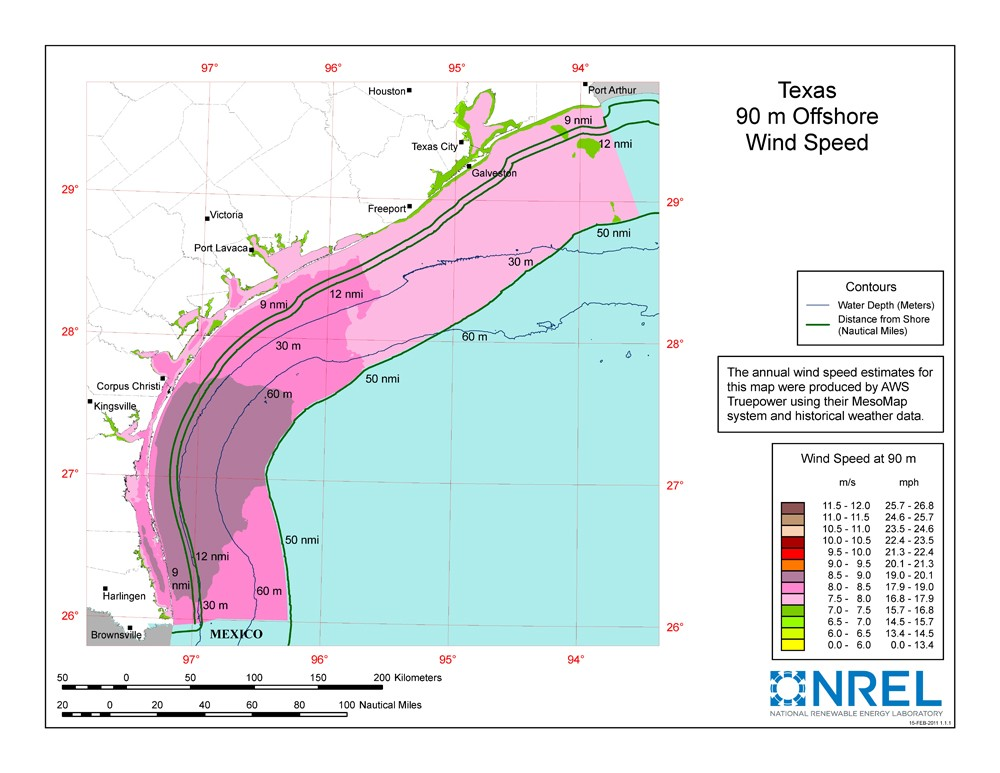

In [447]:
texas_50nm_total_wind = 278353.0
texas_9nm_total_wind = 8928.0 + 45230.0 + 29643.0 + 18990.0

In [448]:
texas_50nm_total_wind

278353.0

In [449]:
texas_9nm_total_wind

102791.0

We will return to these values after computing wind development potential estimates which consider land use restrictions.

## National Renewable Energy Laboratory Wind Supply Curves

The following supply curve wind power capacity estimates take into account varying assumptions about the availability of land for wind power development.  Open access siting assumptions limit land use based only on physical constraints or protected land status.  Limited access siting assumptions include NREL's most restrictive municipal setback and federal management requirements and thus represent the most conservative, or pessimistic, estimate of available wind development potential.

See:[Wind Supply Curves](https://www.nrel.gov/gis/wind-supply-curves.html)

In [450]:
nrel_open = pd.read_csv(datapath+"/NREL/offshore-wind-open-access-siting-regime-atb-mid-turbine-fy21.csv")
nrel_limit = pd.read_csv(datapath+"/NREL/offshore-wind-limited-access-siting-regime-atb-mid-turbine-fy21.csv")

In [451]:
nrel_open.head()

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km
0,0,49.028,-123.286,13.0653,69.437181,0.275788,6.634215,31.441526,-142.296967,9.739686
1,1,49.054,-123.138,3.6531,19.414860,0.270921,6.610088,31.441526,-44.682926,5.595797
2,2,48.942,-123.242,9.7686,51.916454,0.274557,6.625663,31.441526,-143.059708,8.746844
3,3,48.993,-122.948,8.0919,43.005421,0.239673,6.218549,31.441526,-2.659660,5.346195
4,4,48.855,-123.199,0.1701,0.904018,0.273975,6.630000,31.441526,-126.142860,9.316036


The CSV data from NREL must be converted from raw text to a geopandas GeoSeries in order to enable geospatial analysis.  Since we have latitude and longitude data, we apply a geodetic coordinate reference system suitable for North America (NAD83 - EPSG:4269)

See:[North America Geodetic CRS Codes](https://epsg.io/?q=North%20America%20kind%3AGEOGCRS)

In [452]:
nrel_open_geom = gpd.points_from_xy(nrel_open["longitude"], nrel_open["latitude"], crs="EPSG:4269")
nrel_limit_geom = gpd.points_from_xy(nrel_limit["longitude"], nrel_limit["latitude"], crs="EPSG:4269")

In [453]:
nrel_open_geom = gpd.GeoSeries(nrel_open_geom)
nrel_limit_geom = gpd.GeoSeries(nrel_limit_geom)

Add a "geometry" column to each DataFrame accordingly

In [454]:
nrel_open["geometry"] = nrel_open_geom
nrel_limit["geometry"] = nrel_limit_geom

And recast the DataFrame objects to type GeoDataFrame.  Geopandas will automatically recognize the new "geometry" column name as containing valid geolocation data.

In [455]:
nrel_open_gdf = gpd.GeoDataFrame(nrel_open)
nrel_limit_gdf = gpd.GeoDataFrame(nrel_limit)

The data also include effective surface areas associated with each wind capacity estimate, a capacity factor for that area, wind speed, water depth, and distances to the coast and to the nearest onshore electrical transmission tie-in point.

In [456]:
nrel_open_gdf.head()

,Unnamed: 0,latitude,longitude,area_sq_km,capacity_mw,capacity_factor,wind_speed_150meters,landfall_distance_to_transmission_km,bathymetry_meters,distance_to_coast_km,geometry
0,0,49.028,-123.286,13.0653,69.437181,0.275788,6.634215,31.441526,-142.296967,9.739686,POINT (-123.28600 49.02800)
1,1,49.054,-123.138,3.6531,19.414860,0.270921,6.610088,31.441526,-44.682926,5.595797,POINT (-123.13800 49.05400)
2,2,48.942,-123.242,9.7686,51.916454,0.274557,6.625663,31.441526,-143.059708,8.746844,POINT (-123.24200 48.94200)
3,3,48.993,-122.948,8.0919,43.005421,0.239673,6.218549,31.441526,-2.659660,5.346195,POINT (-122.94800 48.99300)
4,4,48.855,-123.199,0.1701,0.904018,0.273975,6.630000,31.441526,-126.142860,9.316036,POINT (-123.19900 48.85500)


## Texas General Land Office Offshore Tracts

The Texas General Land Office provides publicly accessible data files for mapping state-owned offshore land tracts.

See:[Texas GLO Maps and Data](https://www.glo.texas.gov/land/land-management/gis/index.html)

In [457]:
sub_land = gpd.read_file(datapath+"/SSL/SubmergedOTLS.shp")

We need to verify the coordinate reference system being used for these offshore tracts

In [458]:
sub_land.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In order to overlay our wind data onto plots of these offshore tracts, all of the GeoDataFrame objects must be projected onto the same coordinate reference system.  We will therefore project the geodetic data supplied by NREL onto the GLO reference frame.

In [459]:
nrel_open_gdf = nrel_open_gdf.to_crs("EPSG:3857")
nrel_limit_gdf = nrel_limit_gdf.to_crs("EPSG:3857")

If we begin by plotting data as a cloropleth map, we can see the variation of offshore wind capacity estimates over the entire United States coastline, including the Great Lakes.  However, the Texas state offshore tracts are difficult to visualize here.

<AxesSubplot:>

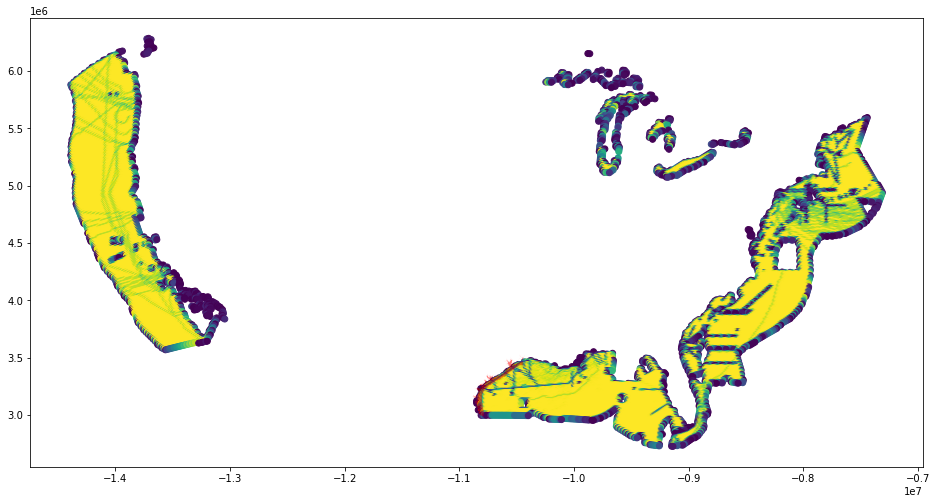

In [460]:
fig, ax = plt.subplots(figsize=(16,12))
nrel_open_gdf.plot(ax=ax, column="capacity_mw")
sub_land.plot(ax=ax, alpha=0.5, color="red")

## Focus on Wind Power Capacity in Texas State Waters

We can zoom in to focus on Texas state waters by returning bounding box coordinates for the GLO offshore tract data

In [461]:
sub_land.total_bounds

array([-10886936.8755,   2993523.1854, -10429325.1377,   3526649.6946])

Here we now see that, as expected, most of the NREL-estimated wind capacity is outside of Texas state waters, but that there are still significant high capacity areas that fall within the GLO offshore tracts.

<AxesSubplot:>

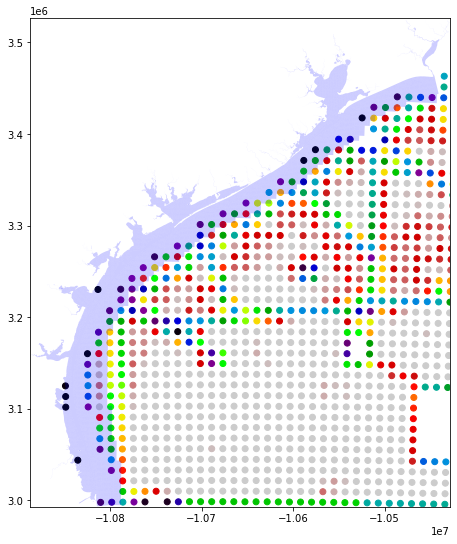

In [462]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-10887000, -10429000])
ax.set_ylim([2993000, 3527000])
nrel_open_gdf.plot(ax=ax, column="capacity_mw", cmap ="nipy_spectral")
sub_land.plot(ax=ax, alpha=0.2, color="blue")

In order to quantify wind power capacity in Texas state waters, we can perform a geospatial join on the NREL and GLO datasets, returning a new GeoDataFrame where NREL wind power capacity estimates fall within the GLO tracts.

In [463]:
wind_open_glo = gpd.sjoin(sub_land, nrel_open_gdf , how="left", op='intersects')
wind_limit_glo = gpd.sjoin(sub_land, nrel_limit_gdf , how="left", op='intersects')

We can sort the intersection data by capacity in MW in descending order if we want to highlight the highest value tracts.

<AxesSubplot:>

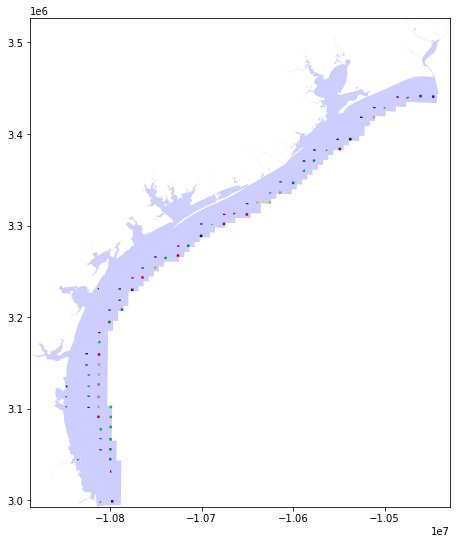

In [464]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-10887000, -10429000])
ax.set_ylim([2993000, 3527000])
wind_open_glo.plot(ax=ax, column="capacity_mw", cmap ="nipy_spectral")
sub_land.plot(ax=ax, alpha=0.2, color="blue")

In [465]:
wind_open_glo["capacity_mw"].sum()

16620.368303571428

<AxesSubplot:>

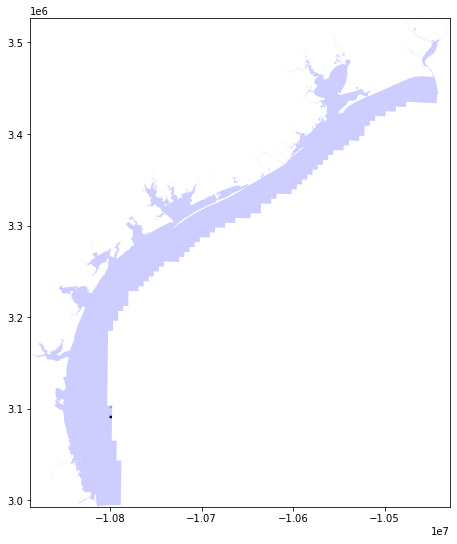

In [466]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim([-10887000, -10429000])
ax.set_ylim([2993000, 3527000])
wind_limit_glo.plot(ax=ax, column="capacity_mw", cmap ="nipy_spectral")
sub_land.plot(ax=ax, alpha=0.2, color="blue")

In [467]:
wind_limit_glo["capacity_mw"].sum()

72.61315237966468

If the strictest land use considerations are applied, only 73 MW of wind development capacity is predicted for Texas state waters by the NREL model; essentially nothing.

In [468]:
texas_all_wind_resource_levels = pd.DataFrame(np.array([[texas_50nm_total_wind, texas_9nm_total_wind, wind_open_glo["capacity_mw"].sum(), wind_limit_glo["capacity_mw"].sum()]]), columns=["Technical 50 nm", "Technical 9 nm", "Open Land Use", "Strict Land Use"])

In [469]:
texas_all_wind_resource_levels.head()

,Technical 50 nm,Technical 9 nm,Open Land Use,Strict Land Use
0,278353.0,102791.0,16620.368304,72.613152


<AxesSubplot:>

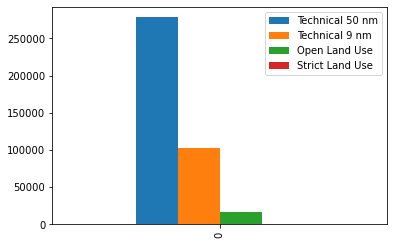

In [470]:
texas_all_wind_resource_levels.plot.bar()

Clearly, the strict land use case is so small to be insignificant by comparison.  The implication of this analysis is that, while Texas has substantial technical wind power potential both in state and federal waters, possible land use restrictions can make an orders-of-magnitude difference in the amount of economic development potential achievable.  For Texas state waters, the range spans 73 MW in the most pessimistic case to 16.6 GW assuming relatively open land use policies, to nearly 103 GW of actual technical wind development potential in the absence of any land use restrictions.